In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
from particles import resampling as rs
import sys
sys.path.append('..')

import banana as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Banana/../utils.py'>

In [2]:
d = 2
sigma = np.sqrt(2)

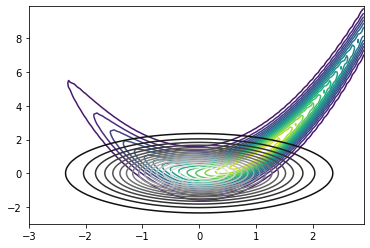

In [3]:
x, y = np.mgrid[-3:3:.1, -3:10:.1]
data = np.dstack((x, y))
z = np.exp(-(sigma**2*(data[:,:, 1]-data[:,:, 0]**2)**2/2+(1-data[:,:, 0])**2/(2*sigma**2)))/(2*np.pi)
zinitial = multivariate_normal.pdf(data, np.array([0, 0]), np.eye(d))
plt.contour(x, y, z, 15)
plt.contour(x, y, zinitial, 15, cmap = 'gray')
# plt.savefig("banana.pdf")

## Algorithms

In [4]:
Niter = 500
gamma = 0.005
N = 300
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)

nmcmc = 20

In [5]:
true_sample = np.zeros((N, d))
true_sample[:, 0] = np.random.normal(loc = 1, scale = sigma, size = N)
true_sample[:, 1] = np.random.normal(loc = true_sample[:, 0]**2, scale = 1/sigma, size = N)

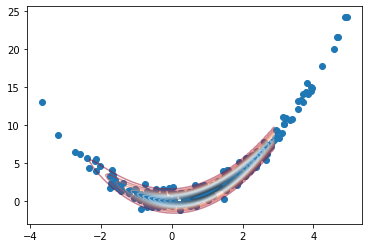

In [6]:
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(true_sample[:,0], true_sample[:,1]);

In [7]:
Niter_ula = Niter
Niter_mala = Niter
Niter_fr = Niter
Niter_smcula = Niter
Niter_smcmala = Niter

In [8]:
gamma_mala = 0.15
gamma_smcmala = 0.45

In [9]:
Nalgo = 6
Nrep = 5

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [10]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, X0, sigma)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain[i,:], accepted_mala = algo.ParallelMALA(gamma_mala, Niter_mala, X0, sigma)
    end = time.time()
    runtime[i, 1] = end-start
    ## SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_FR(gamma, Niter_fr, X0, sigma, nmcmc)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, X0, sigma, nmcmc)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, X0, sigma, nmcmc)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x[i,:], smcmala_w[i,:], accepted_smcmala = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, X0, sigma, nmcmc)
    end = time.time()
    runtime[i, 5] = end-start

In [11]:
np.mean(np.sum(accepted_mala, axis = 0)/Niter_mala)

0.5733933333333334

In [12]:
np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

0.24188771929824565

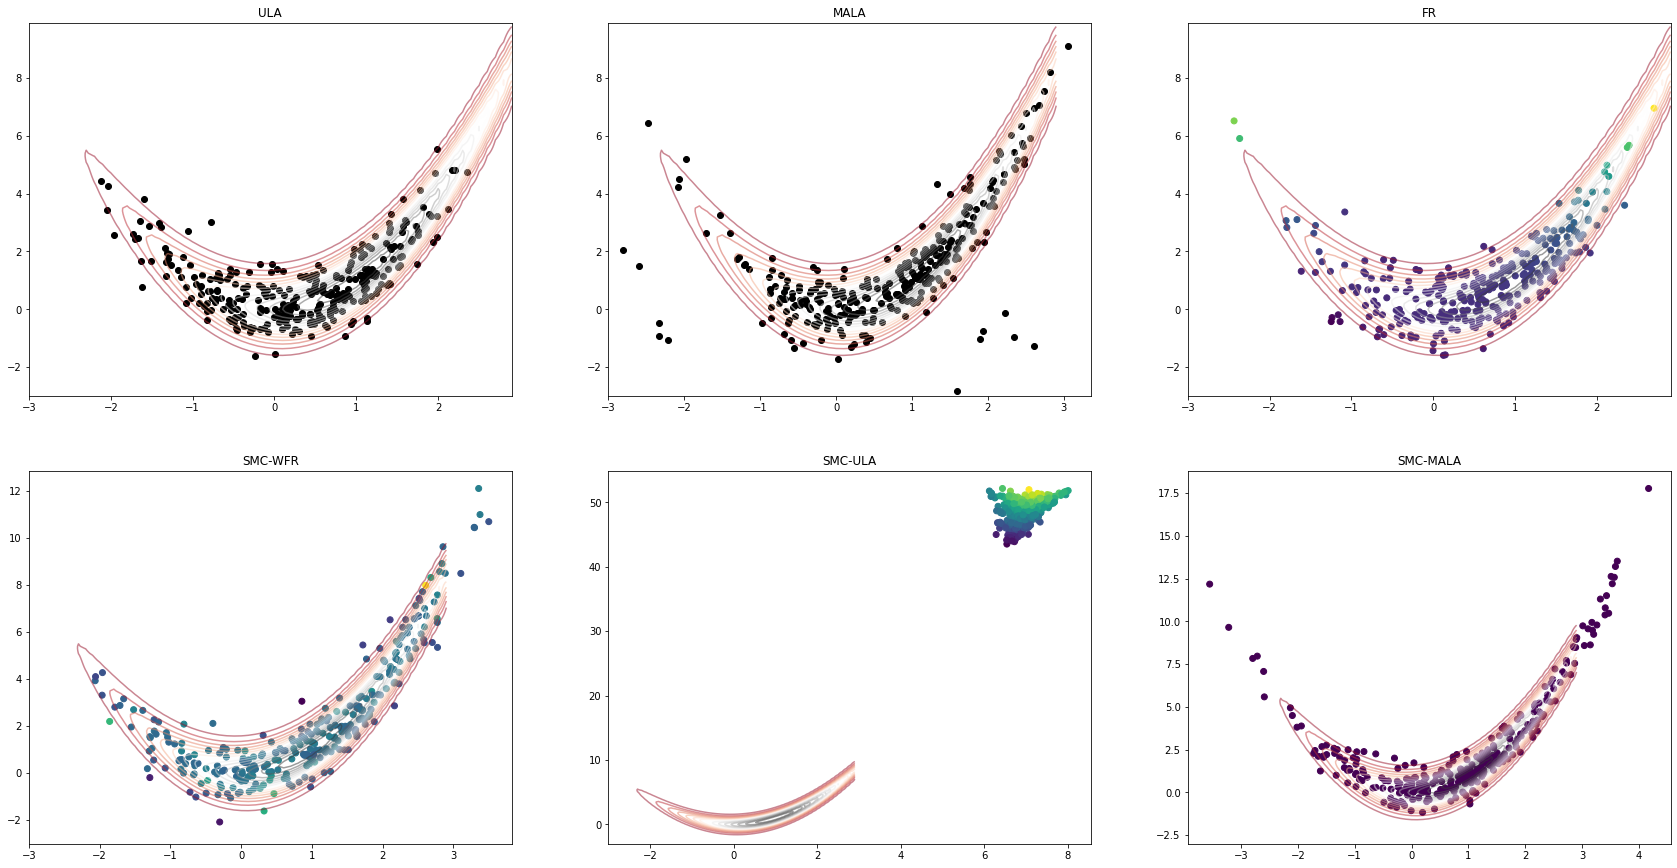

In [13]:
i = Nrep-1
plt.figure(figsize = (12,6))
plt.subplot(2, 3, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(ula_chain[i, -1, 0, :], ula_chain[i, -1, 1, :], color = 'black');
plt.title('ULA')
plt.subplot(2, 3, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(mala_chain[i, -1, 0, :], mala_chain[i, -1, 1, :], color = 'black');
plt.title('MALA')
plt.subplot(2, 3, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(fr_x[i, -1, 0, :], fr_x[i, -1, 1, :], c = fr_w[i, -1, :]);
plt.title('FR')
plt.subplot(2, 3, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[i, -1, 0, :], wfr_x[i, -1, 1, :], c = wfr_w[i, -1, :]);
plt.title('SMC-WFR')
plt.subplot(2, 3, 5)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcula_x[i, -1, 0, :], smcula_x[i, -1, 1, :], c = smcula_w[i, -1, :]);
plt.title('SMC-ULA')
plt.subplot(2, 3, 6)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcmala_x[i, -1, 0, :], smcmala_x[i, -1, 1, :], c = smcmala_w[i, -1, :]);
plt.title('SMC-MALA')
# plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()
# plt.savefig("GaussianMixture4Modes.pdf")

In [14]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime/avg_runtime[3]

array([0.05994065, 0.20611467, 2.18026677, 1.        , 0.45734243,
       3.03321991])

In [15]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [16]:
w1_ula = np.zeros((Nrep, d, Niter_ula))
w1_mala = np.zeros((Nrep, d, Niter_mala))
w1_fr = np.zeros((Nrep, d, Niter_fr))
w1_wfr = np.zeros((Nrep, d, Niter))
w1_smcula = np.zeros((Nrep, d, Niter_smcula))
w1_smcmala = np.zeros((Nrep, d, Niter_smcmala))

mmd_ula = np.zeros((Nrep, Niter_ula))
mmd_mala = np.zeros((Nrep, Niter_mala))
mmd_fr = np.zeros((Nrep, Niter_fr))
mmd_wfr = np.zeros((Nrep, Niter))
mmd_smcula = np.zeros((Nrep, Niter_smcula))
mmd_smcmala = np.zeros((Nrep, Niter_smcmala))

# ksd_ula = np.zeros((Nrep, Niter_ula))
# ksd_mala = np.zeros((Nrep, Niter_mala))
# ksd_fr = np.zeros((Nrep, Niter_fr))
# ksd_wfr = np.zeros((Nrep, Niter))
# ksd_smcula = np.zeros((Nrep, Niter_smcula))
# ksd_smcmala = np.zeros((Nrep, Niter_smcmala))

In [17]:
for j in range(Nrep):
    for i in range(Niter_ula):
#         score_ula = algo.gradient_banana(ula_chain[j, i, :, :])
#         ksd_ula[j, i] = u.kernel_stein_discrepancy_imq_weighted(ula_chain[j, i, :, :].T, score_ula.T)
        mmd_ula[j, i] = u.mmd_rbf(true_sample, ula_chain[j, i, :, :].T)
        for k in range(d):
            w1_ula[j, k, i]  = stats.wasserstein_distance(ula_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter_mala):
#         score_mala = algo.gradient_banana(mala_chain[j, i, :, :])
#         ksd_mala[j, i] = u.kernel_stein_discrepancy_imq_weighted(mala_chain[j, i, :, :].T, score_mala.T)
        mmd_mala[j, i] = u.mmd_rbf(true_sample, mala_chain[j, i, :, :].T)
        for k in range(d):
            w1_mala[j, k, i]  = stats.wasserstein_distance(mala_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter):
#         score_wfr = algo.gradient_banana(wfr_x[j, i, :, :])
#         ksd_wfr[j, i] = u.kernel_stein_discrepancy_imq_weighted(wfr_x[j, i, :, :].T, score_wfr.T, weights = wfr_w[j, i, :])
        mmd_wfr[j, i] = u.mmd_rbf(true_sample, wfr_x[j, i, :, :].T, w = wfr_w[j, i, :])
        for k in range(d):
            w1_wfr[j, k, i]  = stats.wasserstein_distance(wfr_x[j, i, k, :], true_sample[:, k], u_weights = wfr_w[j, i, :])
    for i in range(Niter_fr):
#         score_fr = algo.gradient_banana(fr_x[j, i, :, :])
#         ksd_fr[j, i] = u.kernel_stein_discrepancy_imq_weighted(fr_x[j, i, :, :].T, score_fr.T, weights = fr_w[j, i, :])
        mmd_fr[j, i] = u.mmd_rbf(true_sample, fr_x[j, i, :, :].T, w = fr_w[j, i, :])
        for k in range(d):
            w1_fr[j, k, i]  = stats.wasserstein_distance(fr_x[j, i, k, :], true_sample[:, k], u_weights = fr_w[j, i, :])
    for i in range(Niter_smcula):
#         score_smcula = algo.gradient_banana(smcula_x[j, i, :, :])
#         ksd_smcula[j, i] = u.kernel_stein_discrepancy_imq_weighted(smcula_x[j, i, :, :].T, score_smcula.T, weights = smcula_w[j, i, :])
        mmd_smcula[j, i] = u.mmd_rbf(true_sample, smcula_x[j, i, :, :].T, w = smcula_w[j, i, :])
        for k in range(d):
            w1_smcula[j, k, i]  = stats.wasserstein_distance(smcula_x[j, i, k, :], true_sample[:, k], u_weights = smcula_w[j, i, :])
    for i in range(Niter_smcmala):
#         score_smcmala = algo.gradient_banana(smcmala_x[j, i, :, :])
#         ksd_smcmala[j, i] = u.kernel_stein_discrepancy_imq_weighted(smcmala_x[j, i, :, :].T, score_smcmala.T, weights = smcmala_w[j, i, :])
        mmd_smcmala[j, i] = u.mmd_rbf(true_sample, smcmala_x[j, i, :, :].T, w = smcmala_w[j, i, :])
        for k in range(d):
            w1_smcmala[j, k, i]  = stats.wasserstein_distance(smcmala_x[j, i, k, :], true_sample[:, k], u_weights = smcmala_w[j, i, :])

In [18]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

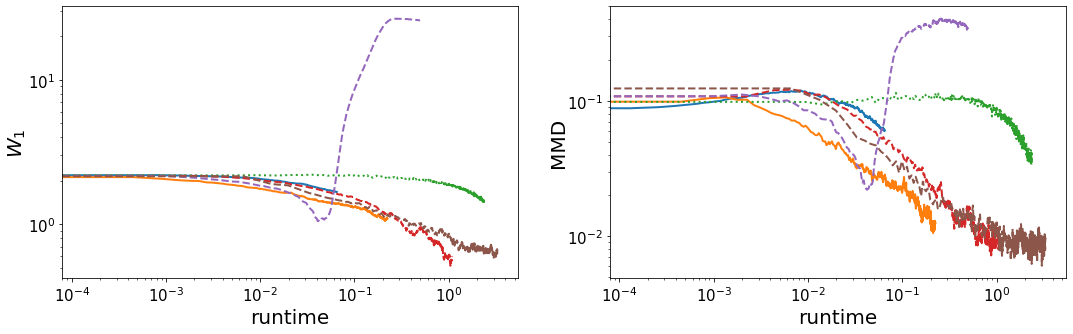

In [19]:
plt.figure(figsize = (18,5))
plt.subplot(1, 2, 1)
plt.semilogy(xx_ula, np.mean(np.mean(w1_ula, axis = 1), axis = 0), label = 'ULA', lw = 2)
plt.loglog(xx_mala, np.mean(np.mean(w1_mala, axis = 1), axis = 0), label = 'MALA', lw = 2, c = colors[1])
plt.plot(xx_fr, np.mean(np.mean(w1_fr, axis = 1), axis = 0), label = 'SMC-FR', lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(xx_wfr, np.mean(np.mean(w1_wfr, axis = 1), axis = 0), label = 'SMC-WFR', lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(xx_smcula, np.mean(np.mean(w1_smcula, axis = 1), axis = 0), label = 'SMC-ULA', lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(xx_smcmala, np.mean(np.mean(w1_smcmala, axis = 1), axis = 0), label = 'SMC-MALA', lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 2, 2)
plt.semilogy(xx_ula, np.mean(mmd_ula, axis = 0), lw = 2)
plt.loglog(xx_mala, np.mean(mmd_mala, axis = 0), lw = 2, c = colors[1])
plt.plot(xx_fr, np.mean(mmd_fr, axis = 0), lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(xx_wfr, np.mean(mmd_wfr, axis = 0), lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(xx_smcula, np.mean(mmd_smcula, axis = 0), lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(xx_smcmala, np.mean(mmd_smcmala, axis = 0), lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.subplot(1, 3, 3)
# # plt.semilogy(xx_ula, np.mean(ksd_ula, axis = 0), lw = 2)
# plt.loglog(xx_mala, np.mean(ksd_mala, axis = 0), lw = 2, c = colors[1])
# plt.plot(xx_fr, np.mean(ksd_fr, axis = 0), lw = 2, linestyle = 'dotted', c = colors[2])
# plt.plot(xx_wfr, np.mean(ksd_wfr, axis = 0), lw = 2, linestyle = 'dashed', c = colors[3])
# # plt.plot(xx_smcula, np.mean(ksd_smcula, axis = 0), lw = 2, linestyle = 'dashed', c = colors[4])
# plt.plot(xx_smcmala, np.mean(ksd_smcmala, axis = 0), lw = 2, linestyle = 'dashed', c = colors[5])
# plt.xlabel('runtime', fontsize = 20)
# plt.ylabel('KSD', fontsize = 20, labelpad=-1)
# plt.xticks(fontsize=15);
# plt.yticks(fontsize=15);
# plt.savefig('conv_runtime_banana.pdf', bbox_inches="tight")

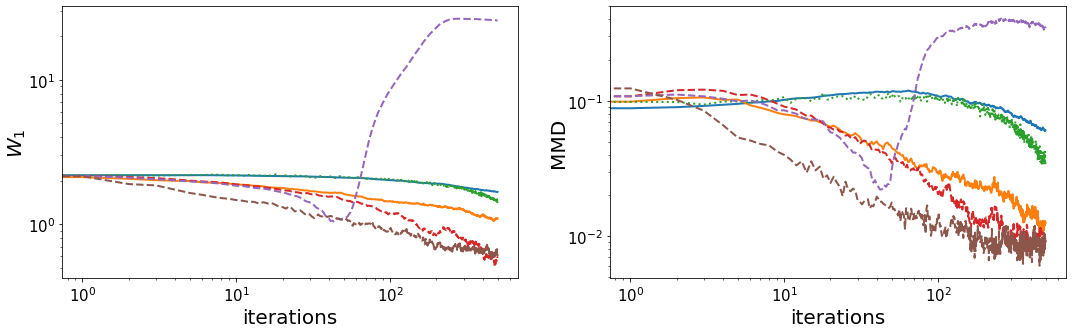

In [20]:
plt.figure(figsize = (18,5))
plt.subplot(1, 2, 1)
plt.loglog(np.mean(np.mean(w1_ula, axis = 1), axis = 0), label = 'ULA', lw = 2)
plt.loglog(np.mean(np.mean(w1_mala, axis = 1), axis = 0), label = 'MALA', lw = 2, c = colors[1])
plt.plot(np.mean(np.mean(w1_fr, axis = 1), axis = 0), label = 'SMC-FR', lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(np.mean(np.mean(w1_wfr, axis = 1), axis = 0), label = 'SMC-WFR', lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(np.mean(np.mean(w1_smcula, axis = 1), axis = 0), label = 'SMC-ULA', lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(np.mean(np.mean(w1_smcmala, axis = 1), axis = 0), label = 'SMC-MALA', lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 2, 2)
plt.loglog(np.mean(mmd_ula, axis = 0), lw = 2)
plt.loglog(np.mean(mmd_mala, axis = 0), lw = 2, c = colors[1])
plt.plot(np.mean(mmd_fr, axis = 0), lw = 2, linestyle = 'dotted', c = colors[2])
plt.plot(np.mean(mmd_wfr, axis = 0), lw = 2, linestyle = 'dashed', c = colors[3])
plt.plot(np.mean(mmd_smcula, axis = 0), lw = 2, linestyle = 'dashed', c = colors[4])
plt.plot(np.mean(mmd_smcmala, axis = 0), lw = 2, linestyle = 'dashed', c = colors[5])
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MMD', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.subplot(1, 3, 3)
# # plt.loglog(np.mean(ksd_ula, axis = 0), lw = 2)
# plt.loglog(np.mean(ksd_mala, axis = 0), lw = 2, c = colors[1])
# plt.plot(np.mean(ksd_fr, axis = 0), lw = 2, linestyle = 'dotted', c = colors[2])
# plt.plot(np.mean(ksd_wfr, axis = 0), lw = 2, linestyle = 'dashed', c = colors[3])
# # plt.plot(np.mean(ksd_smcula, axis = 0), lw = 2, linestyle = 'dashed', c = colors[4])
# plt.plot(np.mean(ksd_smcmala, axis = 0), lw = 2, linestyle = 'dashed', c = colors[5])
# plt.xlabel('iterations', fontsize = 20)
# plt.ylabel('KSD', fontsize = 20, labelpad=-1)
# plt.xticks(fontsize=15);
# plt.yticks(fontsize=15);
# plt.savefig('conv_iter_banana.pdf', bbox_inches="tight")

In [21]:
# # tmp = np.matrix(mmd_ula)
# # with open('mmd_ula.txt','wb') as f:
# #     for line in tmp:
# #         np.savetxt(f, line)
# tmp = np.matrix(mmd_mala)
# with open('mmd_mala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_fr)
# with open('mmd_fr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(mmd_wfr)
# with open('mmd_wfr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# # tmp = np.matrix(mmd_smcula)
# # with open('mmd_smcula.txt','wb') as f:
# #     for line in tmp:
# #         np.savetxt(f, line)
# tmp = np.matrix(mmd_smcmala)
# with open('mmd_smcmala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)

In [22]:
# # tmp = np.matrix(ksd_ula)
# # with open('ksd_ula.txt','wb') as f:
# #     for line in tmp:
# #         np.savetxt(f, line)
# tmp = np.matrix(ksd_mala)
# with open('ksd_mala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_fr)
# with open('ksd_fr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_wfr)
# with open('ksd_wfr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_smcula)
# with open('ksd_smcula.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(ksd_smcmala)
# with open('ksd_smcmala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)

In [23]:
# # tmp = np.matrix(np.mean(w1_ula, axis = 1))
# # with open('w1_ula.txt','wb') as f:
# #     for line in tmp:
# #         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_mala, axis = 1))
# with open('w1_mala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_fr, axis = 1))
# with open('w1_fr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_wfr, axis = 1))
# with open('w1_wfr.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)
# # tmp = np.matrix(np.mean(w1_smcula, axis = 1))
# # with open('w1_smcula.txt','wb') as f:
# #     for line in tmp:
# #         np.savetxt(f, line)
# tmp = np.matrix(np.mean(w1_smcmala, axis = 1))
# with open('w1_smcmala.txt','wb') as f:
#     for line in tmp:
#         np.savetxt(f, line)

In [24]:
# parameters = np.matrix(avg_runtime)
# with open('times.txt','wb') as f:
#     for line in parameters:
#         np.savetxt(f, line)